# Setup

### Load packages

In [89]:
##Import packages
import os
import anndata as ad
import scimap as sm
import importlib

import scanpy as sp
import pandas as pd
import numpy as np
import napari as napari
import math
import seaborn as sns
import itertools

from scipy import stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colors
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from matplotlib.colors import Normalize

import hetmel as hm

In [93]:
importlib.reload(hm)

<module 'hetmel' from '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py'>

### Set up files, directories, variables

Set and go to project directory 

In [77]:
project_dir = "/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/"
case_number = "Case4-2"
os.chdir('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts')

Variables 

In [275]:
phenotype = pd.read_csv('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/20250408_phenotyping_workflow_allcombinations.csv')
image_path="/Volumes/FallahiLab/Maize-Data/Leica-Thunder/Kimberly_Nguyen/20250225_HetMel_Cases1-4/Case4-2/background/Case4-2_final.ome.tif"
feature_table_path = "/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/Case4-2/Case4-2_final_Case4-2_processed_nuclei.csv"

### Read in data

In [69]:
bdata = ad.read_h5ad('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/Case4-2/Case4-2.h5ad')

### Write data

In [289]:
#write adata to a file
adata.write(project_dir + case_number + '/' + 'Case4-2_v3.h5ad')

Read in feature extraction csv and convert to anndata frame 

In [276]:

adata = sm.pp.mcmicro_to_scimap(feature_table_path)

Loading Case4-2_final_Case4-2_processed_nuclei.csv


Set marker subset variables 

In [265]:
#Marker subsets
AP1s = ['cFOS', 'FRA1','FRA2','cJUN','JUNB','JUND']
Diff_state_markers = ['MITF','SOX10','PRAME','AXL','SOX9','NGFR']

Create layers to save log raw data and zscore of the log raw data

In [280]:
adata


AnnData object with n_obs × n_vars = 89031 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid'
    uns: 'all_markers', 'gates'
    layers: 'log', 'log1p_raw', 'zscore'

In [278]:

adata.layers["log1p_raw"] = np.log1p(adata.raw.X) #log layer
adata.layers["zscore"] = stats.zscore(adata.layers["log1p_raw"], axis = 0) #z score log layer
adata

AnnData object with n_obs × n_vars = 89031 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid'
    uns: 'all_markers'
    layers: 'log', 'log1p_raw', 'zscore'

## Check pixel distribution 

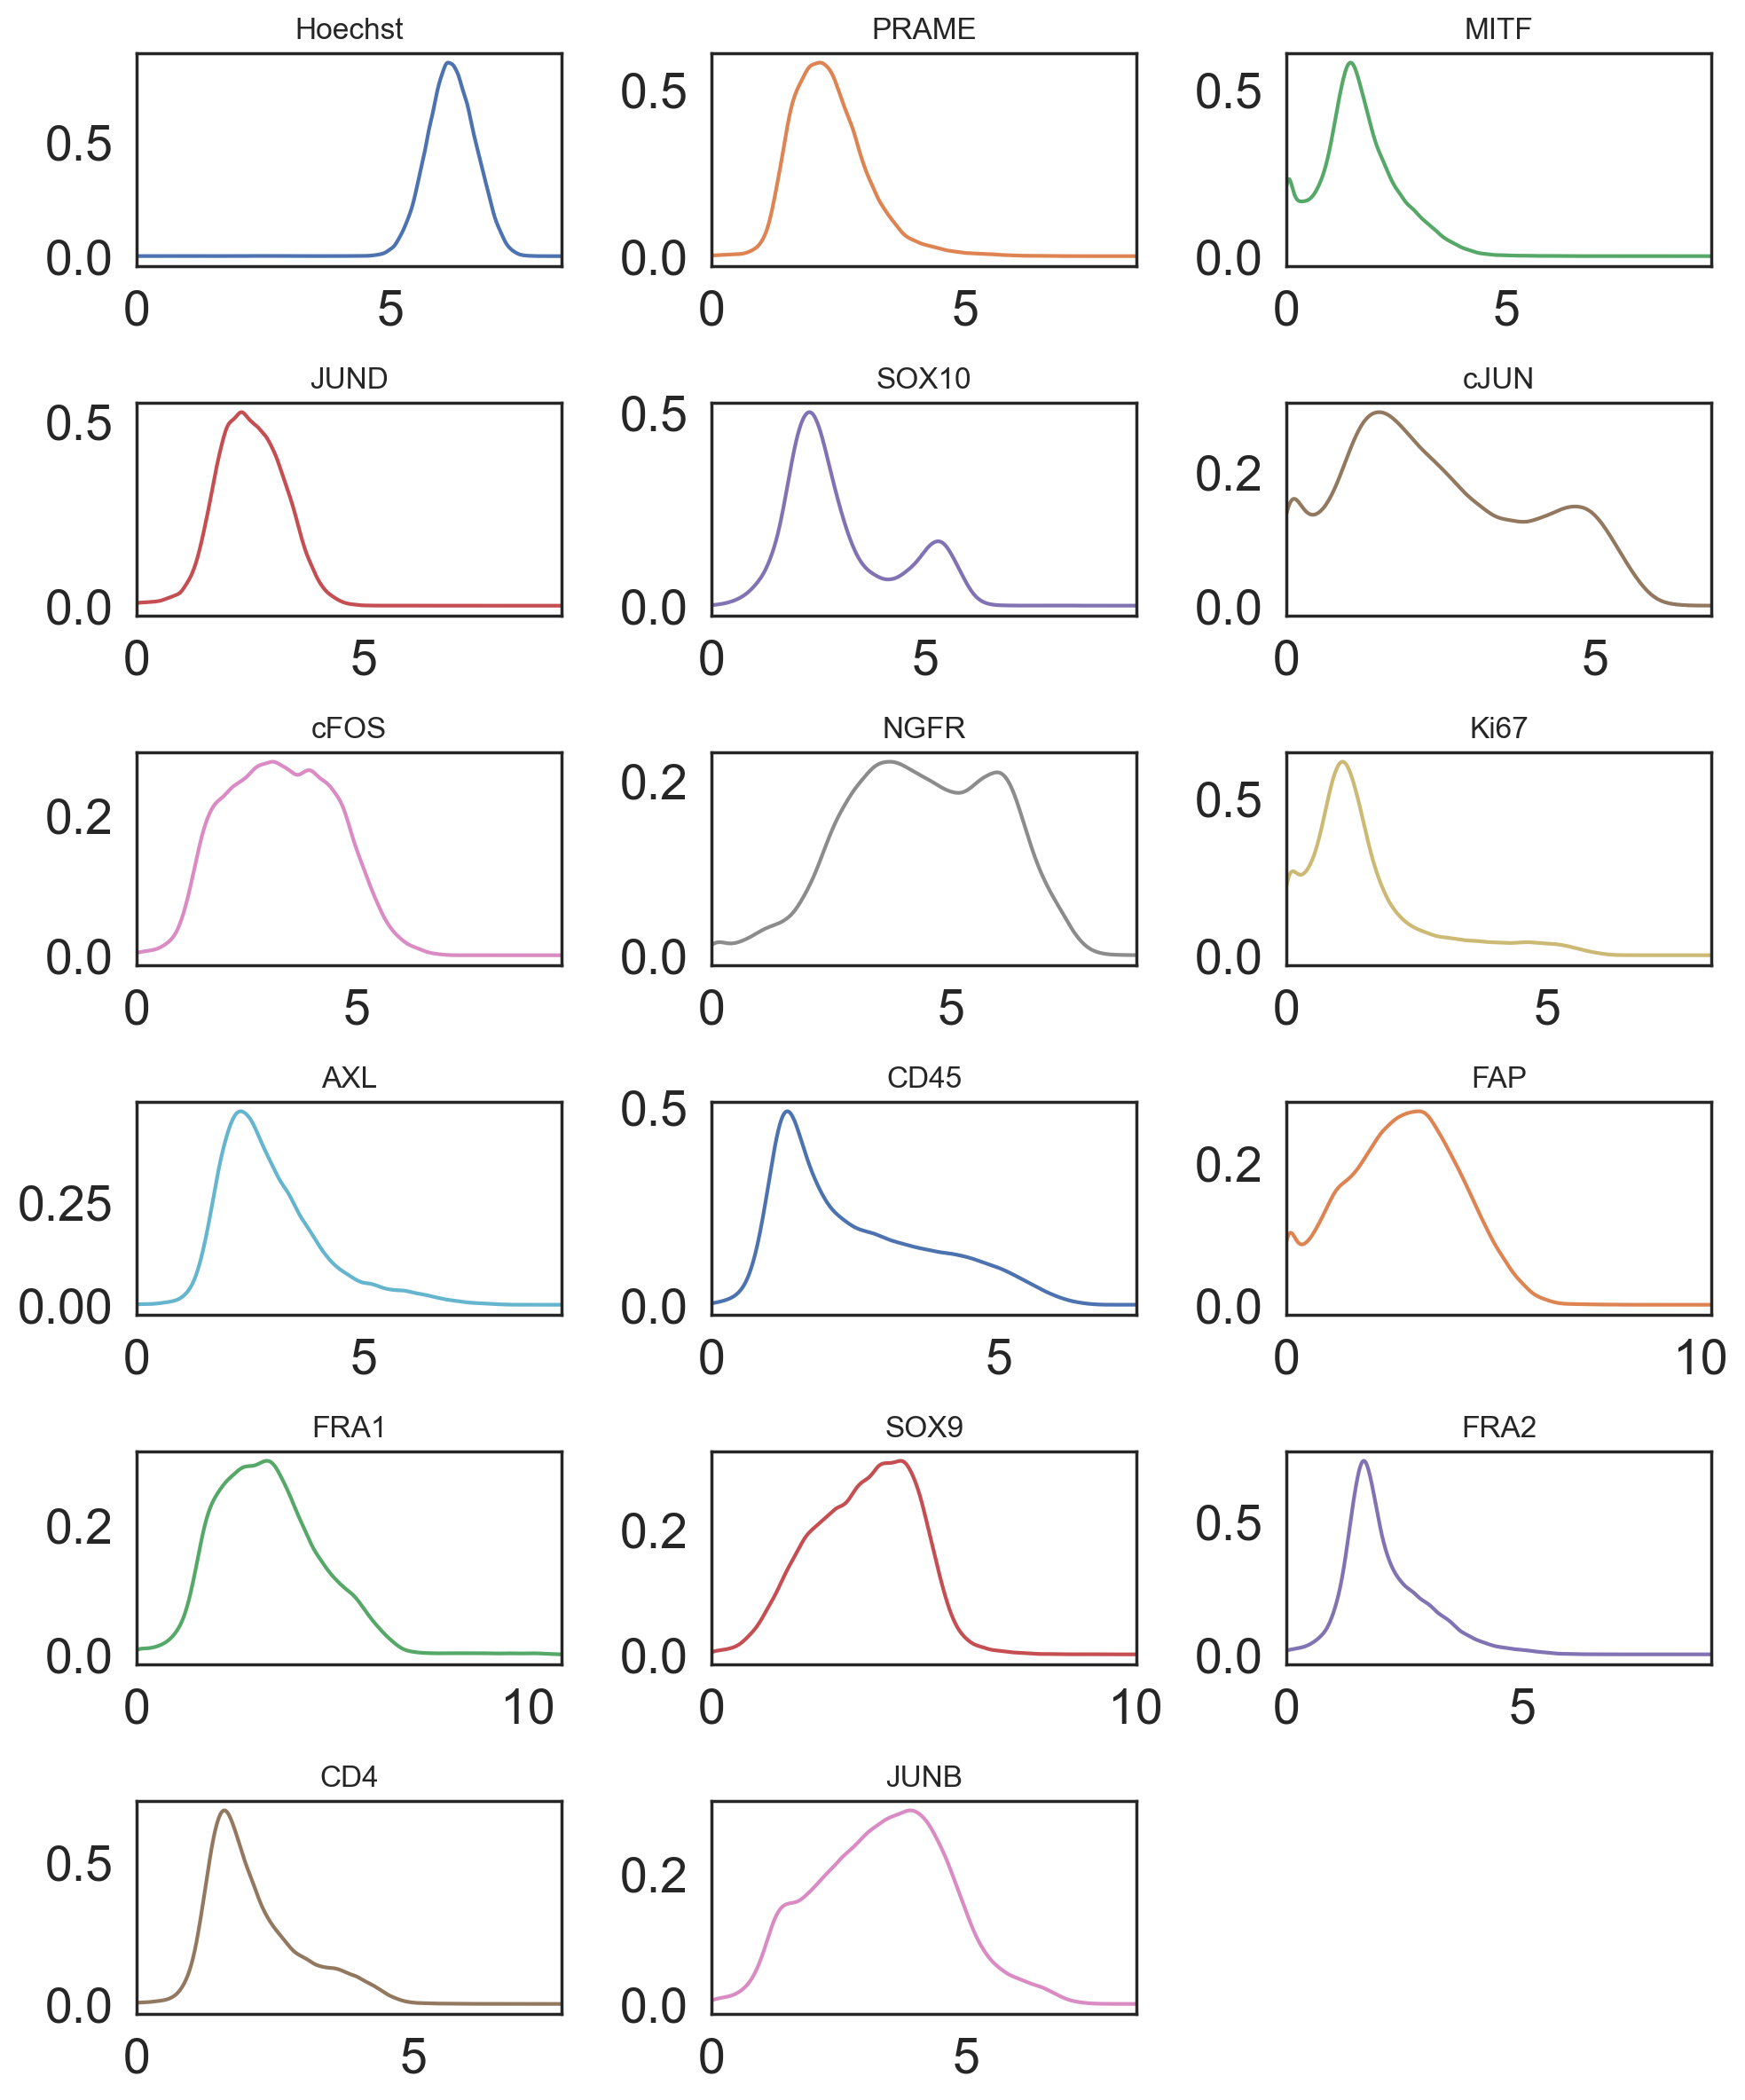

In [44]:
hm.distPlot(adata, layer='log1p_raw',figsize=(10,12),ncols=3, fontsize=20)

## Gating

In [29]:
from tifffile import imread
img_data = imread(image_path)
print(img_data.shape) 

(17, 5496, 9528)


Identify gates to phenotype discrete cell types 

In [ ]:
sm.pl.napariGater (image_path, adata, )#channel_names=['CD45','FAP','MITF','SOX9','SOX10','NGFR','PRAME','AXL' ])

/var/folders/vb/f8_hhkls73qf5938jf5w6rk9dds1_2/T/ipykernel_6627/1802044421.py:1: UserWarning:

NOTE: napariGater() is currently in beta testing. If you encounter any issues, please report them at: https://github.com/labsyspharm/scimap/issues



Initializing...
Initializing gates with GMM...


Loading image data...
Calculating contrast settings...


Saved contrast settings for Case4-2_final_Case4-2_processed_nuclei with 17 channels
Initialization completed in 11.39 seconds
Opening napari viewer...
Napari viewer initialized in 14.60 seconds


Gate confirmed for FAP at 3.70
Gate confirmed for CD45 at 3.20
Gate confirmed for NGFR at 5.00
Gate confirmed for MITF at 2.80


Gate confirmed for SOX10 at 3.50


Gate confirmed for SOX9 at 3.90
Gate confirmed for AXL at 3.70


Alternatively, read in csv file containing gates for desired markers

In [47]:
marker_gates = pd.read_csv('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/Case4-2/Case4-2_markergates.csv',
    header = [0], index_col =[0])

adata.uns['gates'] = marker_gates

OR copy gates from a previous adata file

In [279]:
#bdata = ad.read_h5ad('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/Case4-2/Case4-2.h5ad')
adata.uns['gates'] = bdata.uns['gates']

## Phenotyping

Rescale data in adata.X according to gates.
Values greater than gate scales 0.5-1. Values lower than gate scaled to 0-0.5.

In [281]:
sm.pp.rescale(adata, gate=adata.uns['gates'])


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:145: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Scaling Image: Case4-2_final_Case4-2_processed_nuclei
Scaling Hoechst (gate: 6.419)
Scaling PRAME (gate: 3.000)
Scaling MITF (gate: 2.800)
Scaling JUND (gate: 2.871)
Scaling SOX10 (gate: 3.500)
Scaling cJUN (gate: 3.447)
Scaling cFOS (gate: 3.925)
Scaling NGFR (gate: 5.000)
Scaling Ki67 (gate: 2.702)
Scaling AXL (gate: 3.700)
Scaling CD45 (gate: 3.200)
Scaling FAP (gate: 3.700)
Scaling FRA1 (gate: 4.291)
Scaling SOX9 (gate: 3.900)
Scaling FRA2 (gate: 3.003)
Scaling CD4 (gate: 2.970)
Scaling JUNB (gate: 4.076)


AnnData object with n_obs × n_vars = 89031 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid'
    uns: 'all_markers', 'gates'
    layers: 'log', 'log1p_raw', 'zscore'

Run phenotyping function, generating new adata.obs layer for "phenotype" based on the previously defined phenotyping workflow

In [282]:
phenotype.style.format(na_rep='')
adata= sm.tl.phenotype_cells (adata, phenotype=phenotype, label="phenotype") 


Phenotyping Tumor cell
Phenotyping Fibroblast
Phenotyping Immune Cell
-- Subsetting Tumor cell
Phenotyping MITF+ SOX10+ NGFR+ SOX9+ PRAME+
Phenotyping MITF+ SOX10+ NGFR+ SOX9+
Phenotyping MITF+ SOX10+ NGFR+ PRAME+
Phenotyping MITF+ SOX10+ SOX9+ PRAME+
Phenotyping MITF+ NGFR+ SOX9+ PRAME+
Phenotyping SOX10+ NGFR+ SOX9+ PRAME+
Phenotyping MITF+ SOX10+ NGFR+
Phenotyping MITF+ SOX10+ SOX9+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX10+ PRAME+
Phenotyping MITF+ NGFR+ SOX9+
Phenotyping MITF+ NGFR+ PRAME+
Phenotyping MITF+ SOX9+ PRAME+
Phenotyping SOX10+ NGFR+ SOX9+
Phenotyping SOX10+ NGFR+ PRAME+
Phenotyping SOX10+ SOX9+ PRAME+
Phenotyping NGFR+ SOX9+ PRAME+
Phenotyping MITF+ SOX10+
Phenotyping MITF+ NGFR+
Phenotyping MITF+ SOX9+
Phenotyping MITF+ PRAME+
Phenotyping SOX10+ NGFR+
Phenotyping SOX10+ SOX9+
Phenotyping SOX10+ PRAME+
Phenotyping NGFR+ SOX9+
Phenotyping NGFR+ PRAME+
Phenotyping SOX9+ PRAME+
Phenotyping PRAME+
Phenotyping MITF+
Phenotyping SOX10+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping NGFR+
Phenotyping SOX9+
Phenotyping MITF+ AXL+
Phenotyping SOX10+ AXL+
Phenotyping NGFR+ AXL+
Phenotyping SOX9+ AXL+
Phenotyping PRAME+ AXL+
Phenotyping MITF+ SOX10+ AXL+
Phenotyping MITF+ NGFR+ AXL+
Phenotyping MITF+ SOX9+ AXL+
Phenotyping MITF+ PRAME+ AXL+
Phenotyping SOX10+ NGFR+ AXL+
Phenotyping SOX10+ SOX9+ AXL+
Phenotyping SOX10+ PRAME+ AXL+
Phenotyping NGFR+ SOX9+ AXL+
Phenotyping NGFR+ PRAME+ AXL+
Phenotyping SOX9+ PRAME+ AXL+
Phenotyping MITF+ SOX10+ NGFR+ AXL+
Phenotyping MITF+ SOX10+ SOX9+ AXL+
Phenotyping MITF+ SOX10+ PRAME+ AXL+
Phenotyping MITF+ NGFR+ SOX9+ AXL+
Phenotyping MITF+ NGFR+ PRAME+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Phenotyping MITF+ SOX9+ PRAME+ AXL+
Phenotyping SOX10+ NGFR+ SOX9+ AXL+
Phenotyping SOX10+ NGFR+ PRAME+ AXL+
Phenotyping SOX10+ SOX9+ PRAME+ AXL+
Phenotyping NGFR+ SOX9+ PRAME+ AXL+
Phenotyping AXL+
Phenotyping MITF+ SOX10+ NGFR+ SOX9+ AXL+
Phenotyping MITF+ SOX10+ NGFR+ PRAME+ AXL+
Phenotyping MITF+ SOX10+ SOX9+ PRAME+ AXL+
Phenotyping MITF+ NGFR+ SOX9+ PRAME+ AXL+
Phenotyping SOX10+ NGFR+ SOX9+ PRAME+ AXL+
Phenotyping MITF+ SOX10+ NGFR+ SOX9+ PRAME+ AXL+


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Consolidating the phenotypes across all groups


/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [283]:
adata.obs['phenotype'].value_counts()

phenotype
Unknown                                 28884
Immune Cell                             13306
Tumor cell                              13030
Fibroblast                              10576
SOX10+ NGFR+ SOX9+                       7953
SOX10+ NGFR+ SOX9+ PRAME+                2815
SOX10+ NGFR+                             1618
PRAME+                                   1382
MITF+                                     976
MITF+ SOX9+                               939
SOX10+ NGFR+ SOX9+ AXL+                   832
SOX10+ NGFR+ SOX9+ PRAME+ AXL+            604
SOX9+ PRAME+                              577
PRAME+ AXL+                               454
MITF+ NGFR+ SOX9+                         438
SOX10+ SOX9+                              407
MITF+ NGFR+ SOX9+ AXL+                    375
SOX10+ PRAME+                             372
MITF+ SOX9+ AXL+                          323
SOX10+                                    304
MITF+ AXL+                                289
SOX10+ SOX9+ PRAME+     

Heatmap to check marker expression.
Does tumor cell expression look like any other cell type? If not, relabel "Tumor cell" as "Unknown"

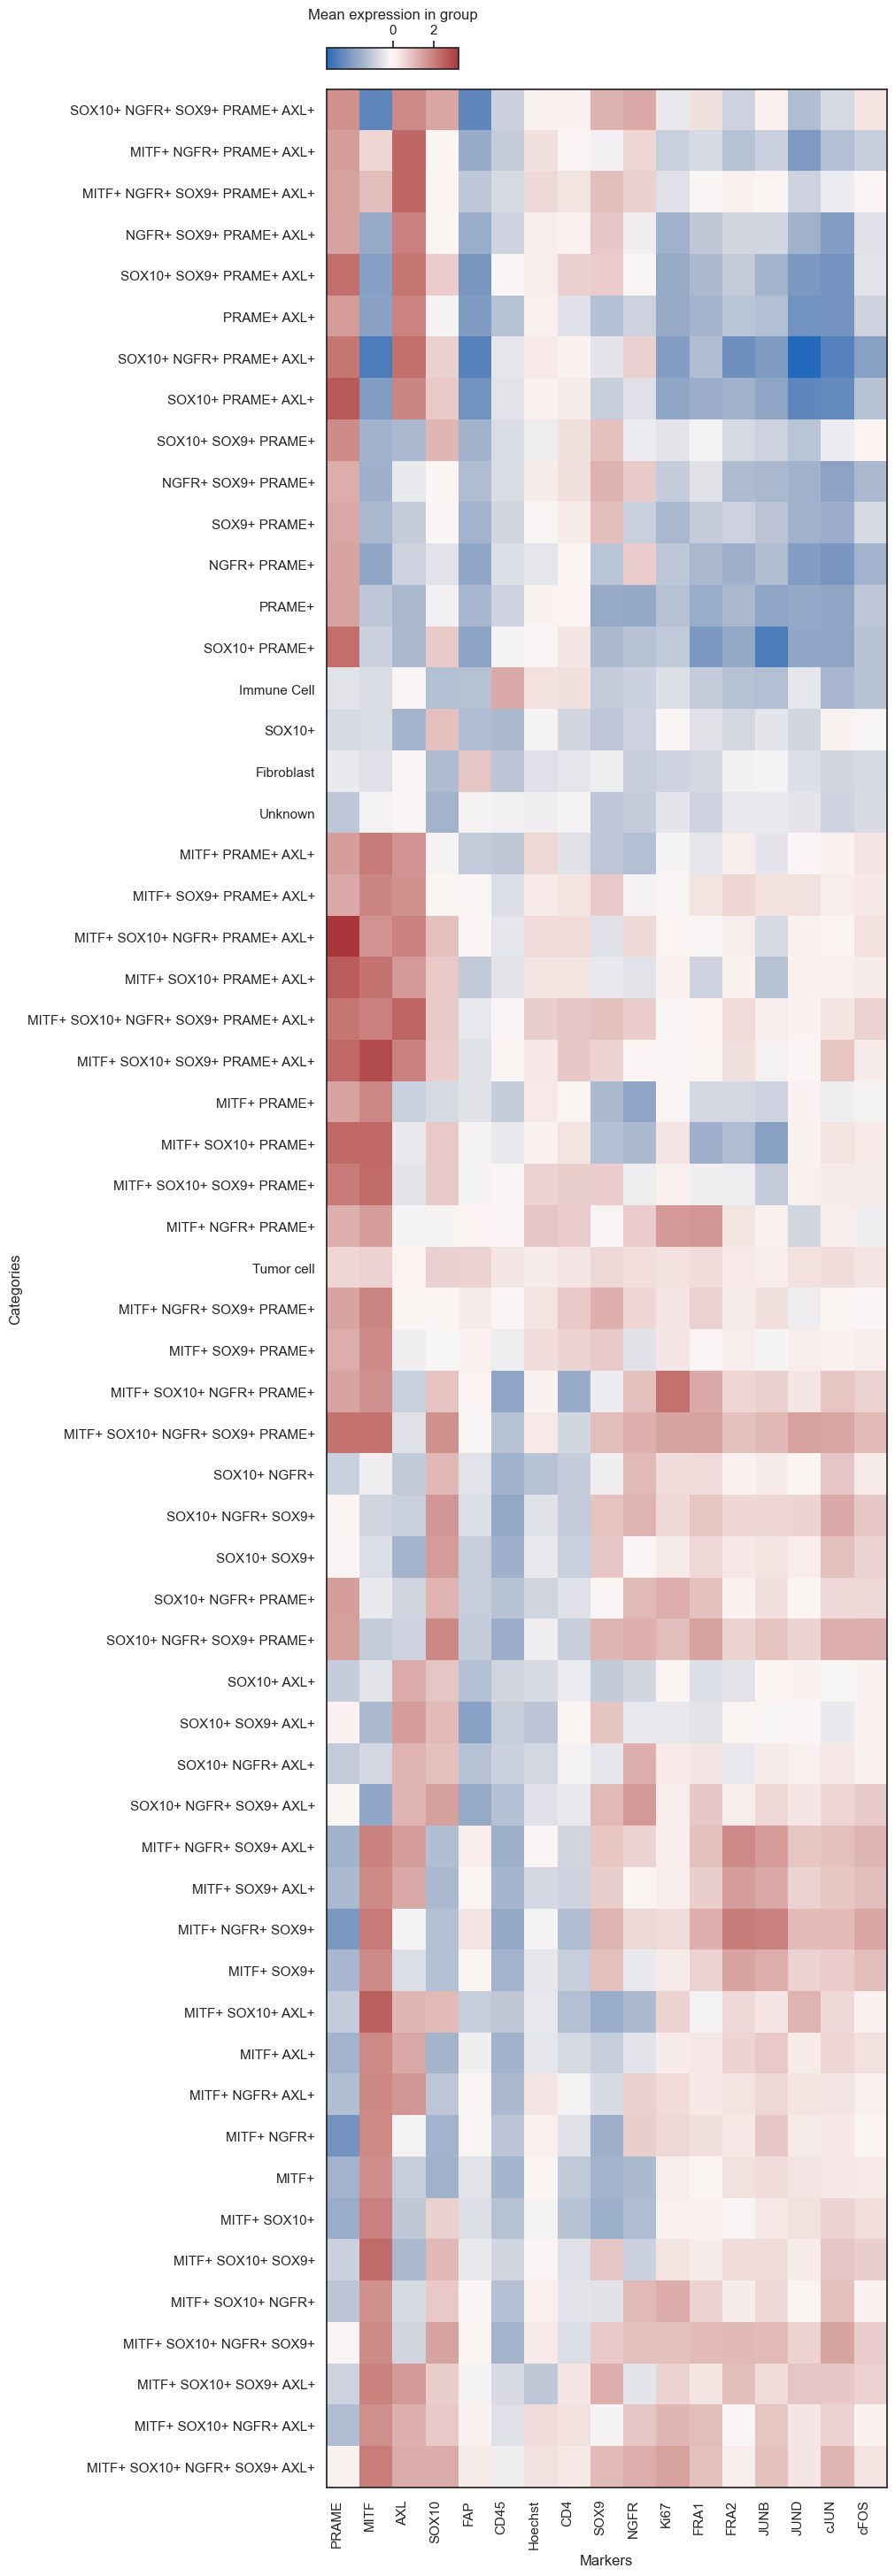

In [284]:
hm.heatmap(adata,groupBy='phenotype',layer='zscore')

In [285]:
adata = hm.replace_phenotype(adata, 'Tumor cell', 'Unknown')

Save adata

In [ ]:
#write adata to a file
adata.write(project_dir + case_number + '/' + 'Case4-2_v3.h5ad')

## Subset adata to focus analysis on tumor cells within tumor ROI

In [75]:
adata

AnnData object with n_obs × n_vars = 89031 × 17
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'phenotype', 'ROI', 'phenotype_category'
    uns: 'all_markers', 'gates'
    layers: 'log', 'log1p_raw', 'zscore'

In [286]:
# Apply the categorize_phenotype function to create a new column in adata.obs
# Categorizes each cell as Tumor, TME, or Other based on the phenotype
adata.obs['phenotype_category'] = adata.obs['phenotype'].apply(hm.categorize_phenotype)
# Display the updated adata.obs
adata.obs.head()

,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,CellID,imageid,phenotype,phenotype_category
Case4-2_final_Case4-2_processed_nuclei_1,141.333333,3.208333,48.0,8.777094,7.105660,0.587025,0.960000,0.857143,0.258275,1,Case4-2_final_Case4-2_processed_nuclei,MITF+ NGFR+ SOX9+,Tumor
Case4-2_final_Case4-2_processed_nuclei_2,161.465116,3.813953,43.0,8.287052,7.025392,0.530388,0.895833,0.671875,-0.670622,2,Case4-2_final_Case4-2_processed_nuclei,Unknown,Other
Case4-2_final_Case4-2_processed_nuclei_3,168.525000,2.150000,40.0,9.086156,5.888274,0.761599,0.869565,0.833333,1.428118,3,Case4-2_final_Case4-2_processed_nuclei,Unknown,Other
Case4-2_final_Case4-2_processed_nuclei_4,184.186667,3.346667,75.0,11.229225,8.632351,0.639562,0.961538,0.852273,-1.349134,4,Case4-2_final_Case4-2_processed_nuclei,MITF+ SOX9+,Tumor
Case4-2_final_Case4-2_processed_nuclei_5,223.767442,2.232558,43.0,9.104435,6.178131,0.734522,0.977273,0.895833,1.325385,5,Case4-2_final_Case4-2_processed_nuclei,Unknown,Other


Add ROIs using napari

In [55]:
###add ROIS
%gui qt
sm.pl.addROI_image(image_path, adata)
adata.obs['ROI'].value_counts()


        Opening Napari;
        Add shape layers (on left) to draw ROI's. 
        Rename the shape layer to give a name to your ROI
        Multiple shape layers are supported
        ROI's should not overlap
        Close Napari to save ROI's.
        


Identifying cells within selected ROI's
ROIs saved under adata.obs['ROI']


ROI
Other          36354
Tumor_right    30016
Tumor_left     22661
Name: count, dtype: int64

OR copy ROIs from a previous adata file

In [287]:
adata.obs['ROI'] = bdata.obs['ROI']

Create new tumor.adata object with only tumor cells

In [288]:
#subset adata for cells with Tumor phenotype and Tumor ROI
tumor_adata = adata[(adata.obs['phenotype_category'] == 'Tumor') & (adata.obs['ROI'].str.contains('Tumor', na=False, case=False))]
tumor_adata.obs['ROI'].value_counts()
tumor_adata.write(project_dir + case_number +'/' + "ROI_tumor_adata_v3.h5ad")

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/Users/zqn7td/anaconda3/envs/scimap/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



Inspect tumor adata

In [290]:
tumor_adata.obs.head()


,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation,CellID,imageid,phenotype,phenotype_category,ROI
Case4-2_final_Case4-2_processed_nuclei_11112,1395.562500,1166.562500,48.0,7.831560,7.823575,0.045145,0.923077,0.750000,-0.785398,11112,Case4-2_final_Case4-2_processed_nuclei,SOX10+ NGFR+ SOX9+ AXL+,Tumor,Tumor_left
Case4-2_final_Case4-2_processed_nuclei_11239,1668.589744,1176.000000,39.0,7.358930,6.700506,0.413449,0.951220,0.795918,0.000000,11239,Case4-2_final_Case4-2_processed_nuclei,PRAME+,Tumor,Tumor_left
Case4-2_final_Case4-2_processed_nuclei_11685,1621.268817,1221.150538,93.0,12.474572,9.509792,0.647184,0.939394,0.768595,0.841457,11685,Case4-2_final_Case4-2_processed_nuclei,MITF+ SOX9+,Tumor,Tumor_left
Case4-2_final_Case4-2_processed_nuclei_11705,1450.428571,1221.551020,49.0,8.123987,7.751234,0.299434,0.924528,0.765625,-0.950547,11705,Case4-2_final_Case4-2_processed_nuclei,SOX10+ NGFR+,Tumor,Tumor_left
Case4-2_final_Case4-2_processed_nuclei_11845,1776.666667,1232.125000,48.0,8.394400,7.314798,0.490590,0.905660,0.750000,-0.878475,11845,Case4-2_final_Case4-2_processed_nuclei,SOX10+ NGFR+ AXL+,Tumor,Tumor_left


In [291]:
tumor_adata.obs['phenotype'].value_counts()

phenotype
SOX10+ NGFR+ SOX9+                      7840
SOX10+ NGFR+ SOX9+ PRAME+               2771
SOX10+ NGFR+                            1578
SOX10+ NGFR+ SOX9+ AXL+                  795
SOX10+ NGFR+ SOX9+ PRAME+ AXL+           410
PRAME+                                   345
SOX10+ SOX9+                             326
SOX10+                                   188
MITF+                                    169
SOX10+ NGFR+ AXL+                        157
SOX10+ SOX9+ PRAME+                      148
PRAME+ AXL+                              117
SOX9+ PRAME+                             115
MITF+ NGFR+                              105
SOX10+ NGFR+ PRAME+                       94
SOX10+ PRAME+                             65
NGFR+ SOX9+ PRAME+ AXL+                   59
MITF+ SOX10+ NGFR+ SOX9+                  54
SOX10+ SOX9+ PRAME+ AXL+                  50
SOX10+ PRAME+ AXL+                        40
MITF+ SOX10+ NGFR+ SOX9+ PRAME+           38
NGFR+ PRAME+                              32


## High-res heatmap of diff states vs AP-1 

Check cell states in tumor cells in order of prevalence, thresholding to exclude super rare states/likely artefacts

In [293]:
phenotype_subset = hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001,verbose=True)

                                 count
phenotype                             
SOX10+ NGFR+ SOX9+                7840
SOX10+ NGFR+ SOX9+ PRAME+         2771
SOX10+ NGFR+                      1578
SOX10+ NGFR+ SOX9+ AXL+            795
SOX10+ NGFR+ SOX9+ PRAME+ AXL+     410
PRAME+                             345
SOX10+ SOX9+                       326
SOX10+                             188
MITF+                              169
SOX10+ NGFR+ AXL+                  157
SOX10+ SOX9+ PRAME+                148
PRAME+ AXL+                        117
SOX9+ PRAME+                       115
MITF+ NGFR+                        105
SOX10+ NGFR+ PRAME+                 94
SOX10+ PRAME+                       65
NGFR+ SOX9+ PRAME+ AXL+             59
MITF+ SOX10+ NGFR+ SOX9+            54
SOX10+ SOX9+ PRAME+ AXL+            50
SOX10+ PRAME+ AXL+                  40
MITF+ SOX10+ NGFR+ SOX9+ PRAME+     38
NGFR+ PRAME+                        32
MITF+ SOX10+ NGFR+                  32
MITF+ AXL+               

### Heatmap of phenotyped cell states vs diff state marker levels

Read in data if necessary

In [157]:
tumor_adata = ad.read_h5ad('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/20250225_HetMel_Cases1-4_analysis/Case4-2/ROI_tumor_adata_v2.h5ad')

Reloading hetmel module to implement any changes to function in hetmel.py

In [254]:
os.chdir('/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts')
importlib.reload(hm)


<module 'hetmel' from '/Volumes/FallahiLab/Maize-Data/People/Kim_Nguyen/AP-1_HetMel_analysis/Scripts/hetmel.py'>

                                 count
phenotype                             
SOX10+ NGFR+ SOX9+                7840
SOX10+ NGFR+ SOX9+ PRAME+         2771
SOX10+ NGFR+                      1578
SOX10+ NGFR+ SOX9+ AXL+            795
SOX10+ NGFR+ SOX9+ PRAME+ AXL+     410
PRAME+                             345
SOX10+ SOX9+                       326
SOX10+                             188
MITF+                              169
SOX10+ NGFR+ AXL+                  157
SOX10+ SOX9+ PRAME+                148
PRAME+ AXL+                        117
SOX9+ PRAME+                       115
MITF+ NGFR+                        105
SOX10+ NGFR+ PRAME+                 94
SOX10+ PRAME+                       65
NGFR+ SOX9+ PRAME+ AXL+             59
MITF+ SOX10+ NGFR+ SOX9+            54
SOX10+ SOX9+ PRAME+ AXL+            50
SOX10+ PRAME+ AXL+                  40
MITF+ SOX10+ NGFR+ SOX9+ PRAME+     38
NGFR+ PRAME+                        32
MITF+ SOX10+ NGFR+                  32
MITF+ AXL+               

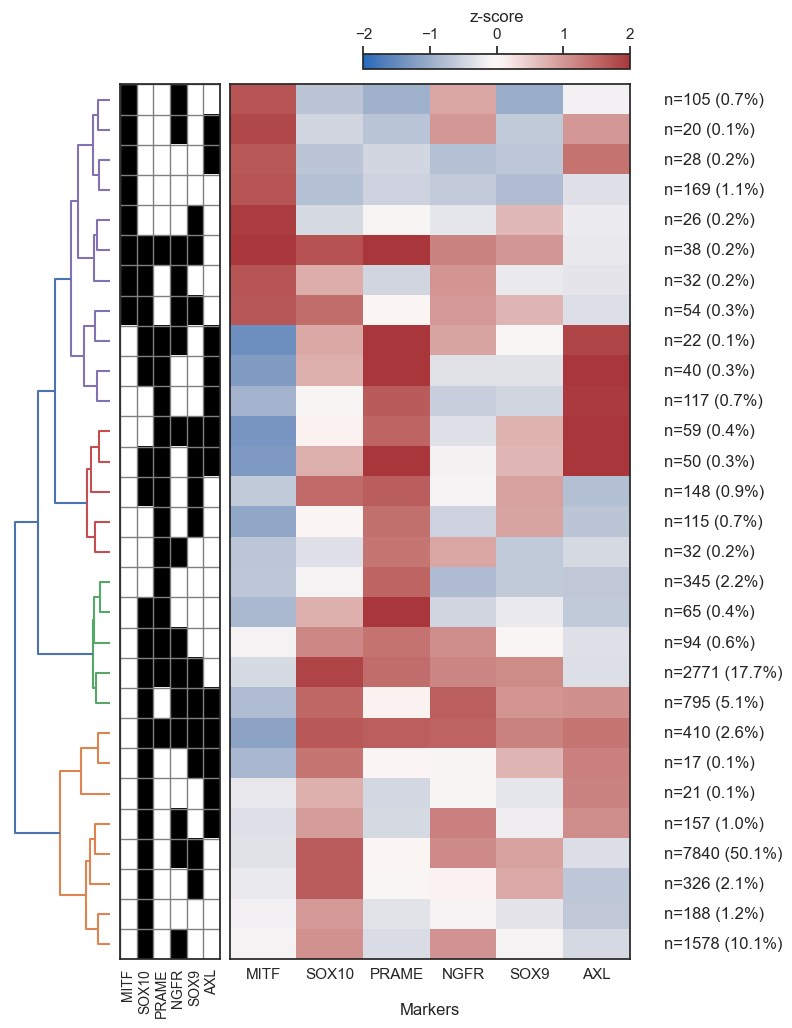

''

In [312]:
phenotype_subset = hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001, verbose=True)
subsetMarkers = ['MITF','SOX10','PRAME','NGFR','SOX9','AXL']
subsetGroups = phenotype_subset
hm.heatmapnew(tumor_adata, groupBy='phenotype', layer = 'zscore' , 
            standardScale=None, subsetMarkers=subsetMarkers, subsetGroups = subsetGroups,
            figsize=(8,15), showPrevalence=True, clusterColumns=True, clusterRows=True, scale_title ='z-score',
            dend_threshold=5.5, 
            clustering_method='ward',  #single, complete, average, ward, weighted, centroid
            phenotype_labels=['MITF','SOX10','PRAME','NGFR','SOX9','AXL'],
            vmin=-2, vmax=2  )
,

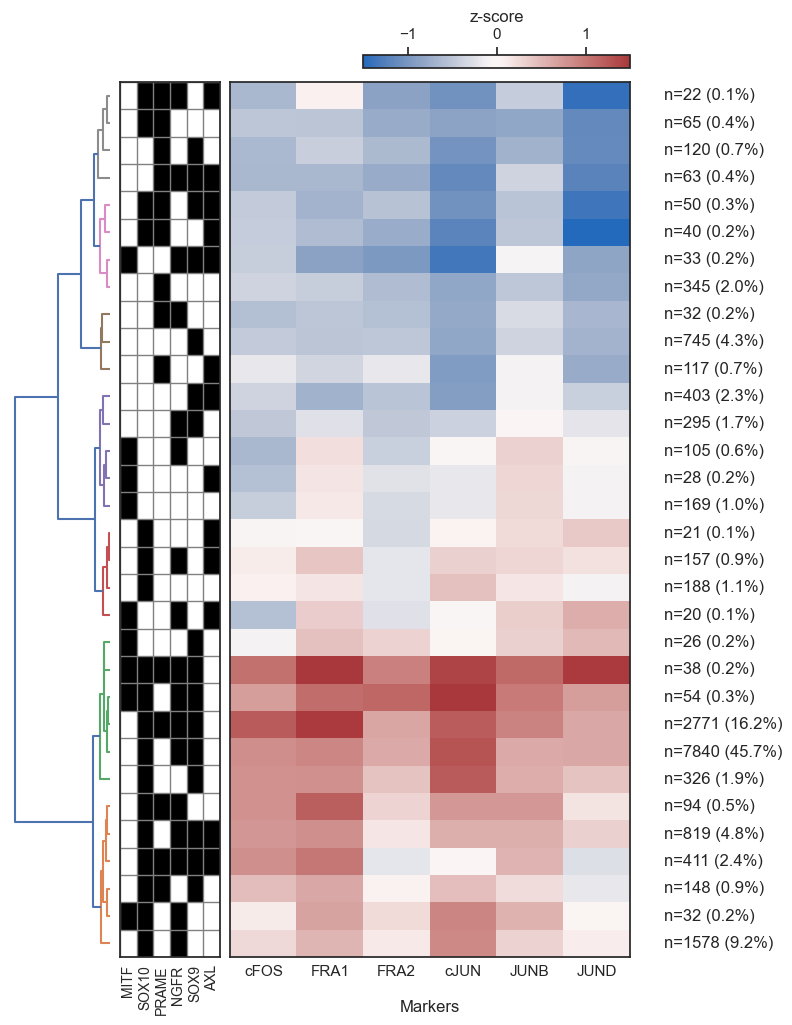

''

In [257]:
phenotype_subset = hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001, verbose=False)
subsetMarkers = ['cFOS', 'FRA1', 'FRA2', 'cJUN', 'JUNB', 'JUND']
subsetGroups = phenotype_subset
hm.heatmapnew(tumor_adata, groupBy='phenotype', layer = 'zscore' , 
            standardScale=None, subsetMarkers=subsetMarkers, subsetGroups = subsetGroups,
            figsize=(8,15), showPrevalence=True, clusterColumns=True, clusterRows=True, scale_title ='z-score',
            dend_threshold=1.5, 
            clustering_method='ward',
            phenotype_labels=['MITF','SOX10','PRAME','NGFR','SOX9','AXL'],
            vmin=-1.5, vmax=1.5  )
,

                                      count
phenotype                                  
MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL-   7840
MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL-   2771
MITF- SOX10+ PRAME- NGFR+ SOX9- AXL-   1578
MITF- SOX10+ PRAME- NGFR+ SOX9+ AXL+    819
MITF- SOX10- PRAME- NGFR- SOX9+ AXL-    745
MITF- SOX10+ PRAME+ NGFR+ SOX9+ AXL+    411
MITF- SOX10- PRAME- NGFR- SOX9+ AXL+    403
MITF- SOX10- PRAME+ NGFR- SOX9- AXL-    345
MITF- SOX10+ PRAME- NGFR- SOX9+ AXL-    326
MITF- SOX10- PRAME- NGFR+ SOX9+ AXL-    295
MITF- SOX10+ PRAME- NGFR- SOX9- AXL-    188
MITF+ SOX10- PRAME- NGFR- SOX9- AXL-    169
MITF- SOX10+ PRAME- NGFR+ SOX9- AXL+    157
MITF- SOX10+ PRAME+ NGFR- SOX9+ AXL-    148
MITF- SOX10- PRAME+ NGFR- SOX9+ AXL-    120
MITF- SOX10- PRAME+ NGFR- SOX9- AXL+    117
MITF+ SOX10- PRAME- NGFR+ SOX9- AXL-    105
MITF- SOX10+ PRAME+ NGFR+ SOX9- AXL-     94
MITF- SOX10+ PRAME+ NGFR- SOX9- AXL-     65
MITF- SOX10- PRAME+ NGFR+ SOX9+ AXL+     63
MITF+ SOX10+ PRAME- NGFR+ SOX9+ 

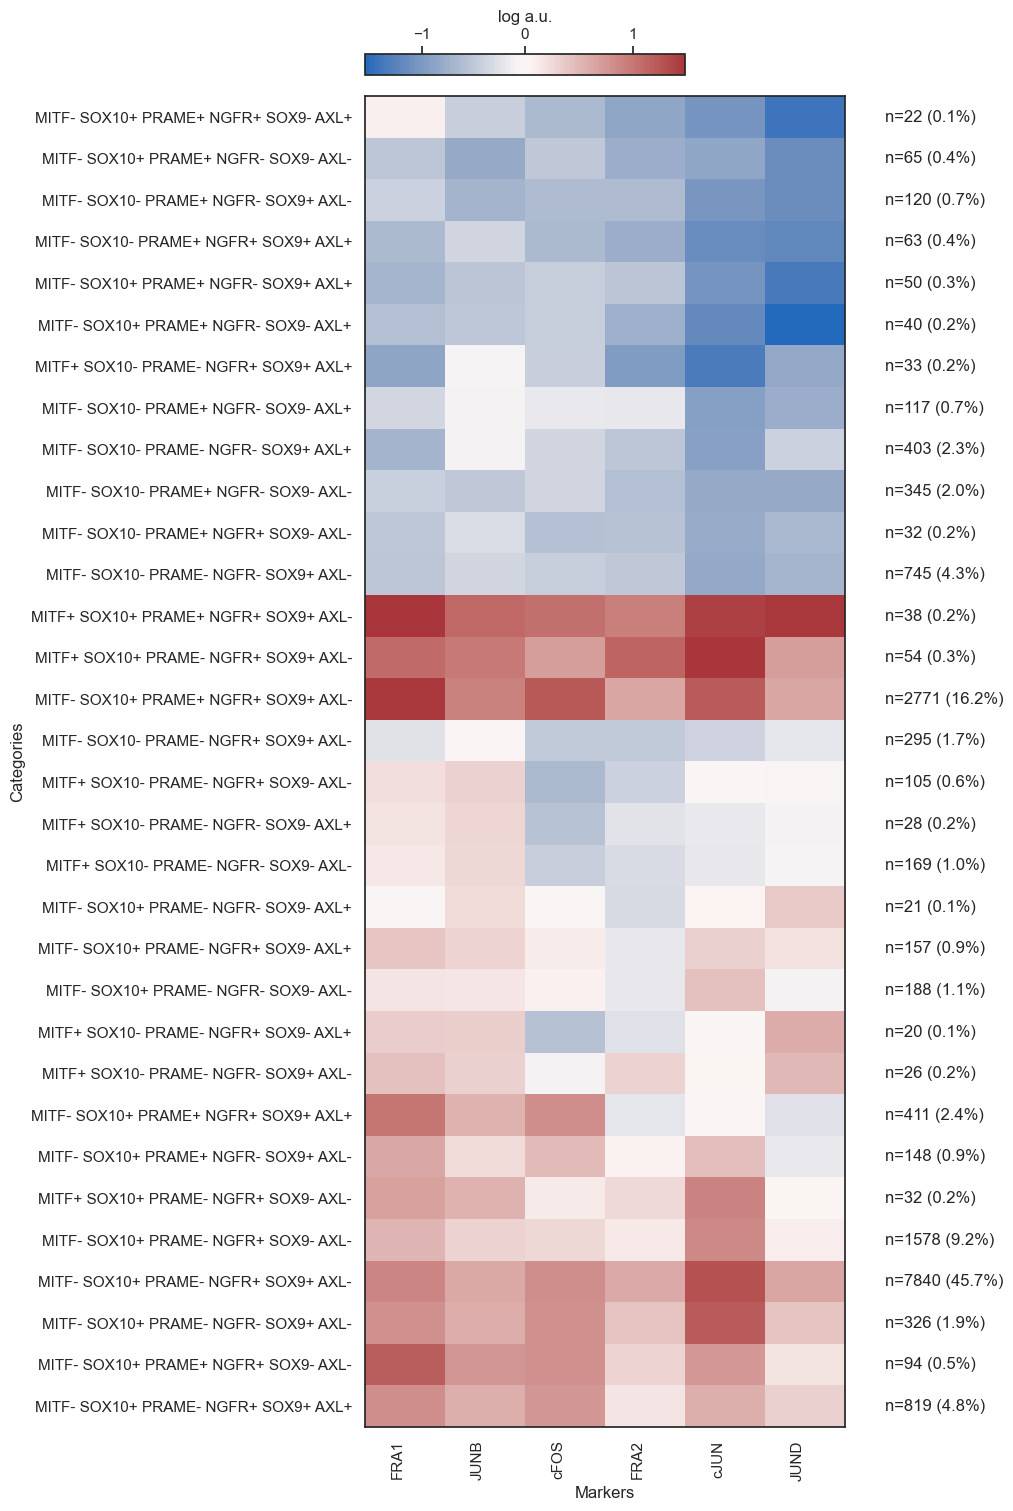

In [85]:
#Z-score heatmap

phenotype_subset = hm.threshold_phenotype_by_prevalence(tumor_adata, threshold=0.001)
subsetMarkers = ['cFOS', 'FRA1', 'FRA2', 'cJUN', 'JUNB', 'JUND']
subsetGroups = phenotype_subset
hm.heatmap(tumor_adata, groupBy='phenotype', layer = 'zscore' , 
            standardScale=None, subsetMarkers=subsetMarkers, subsetGroups = subsetGroups,
            figsize=(10,15), showPrevalence=True, clusterColumns=True, clusterRows=True, scale_title ='log a.u.'
              )
#vmin=-2, vmax=2,